In [5]:
import os
from fidelity_simulation import FidelitySimulation
from pulse import RectangularReadoutPulse

In [6]:
current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "data")
s_parameters_file_state_1 = os.path.join(
    data_dir_path,
    "hfss_resonance_simulator_Resonator_7252612e-6GHz_2_ports_v12_shifted_mock_156_kHz.s2p",
)
s_parameters_file_state_0 = os.path.join(
    data_dir_path,
    "hfss_resonance_simulator_Resonator_7252612e-6GHz_2_ports_v12.s2p"
)

shift_f = 156 * 10 ** 3
f_state_0 = 7.2669 * 10 ** 9
pulse_frequency = f_state_0 + shift_f / 2

In [7]:
def run(pulse_samples_number):
    pulse_length = 3.5 * 10 ** (-6)

    print("simulation dt =", pulse_length / pulse_samples_number * 10 ** 9, "ns")

    rect_readout_pulse = RectangularReadoutPulse(
        carrier_frequency=pulse_frequency,
        pulse_duration=pulse_length,
        pulse_power_dbm=-140,
        total_signal_time=pulse_length,
        pulse_samples_number=pulse_samples_number,
    )

    rect_readout_pulse.plot_pulse()

    fidelity_simulation = FidelitySimulation(
        s_parameters_file_state_0=s_parameters_file_state_0,
        s_parameters_file_state_1=s_parameters_file_state_1,
        readout_pulse=rect_readout_pulse,
        IQ_projection_frequency=pulse_frequency+10e6, # f_fi = 10MHz
        num_iterations=500,
        readout_dt=3e-9,
        plot_pulses=False,
        plot_result=True,
        disable_progress_bar=False,
    )

    fidelity = fidelity_simulation.run()

    print("fidelity =", fidelity)


simulation dt = 0.0004172325134277344 ns


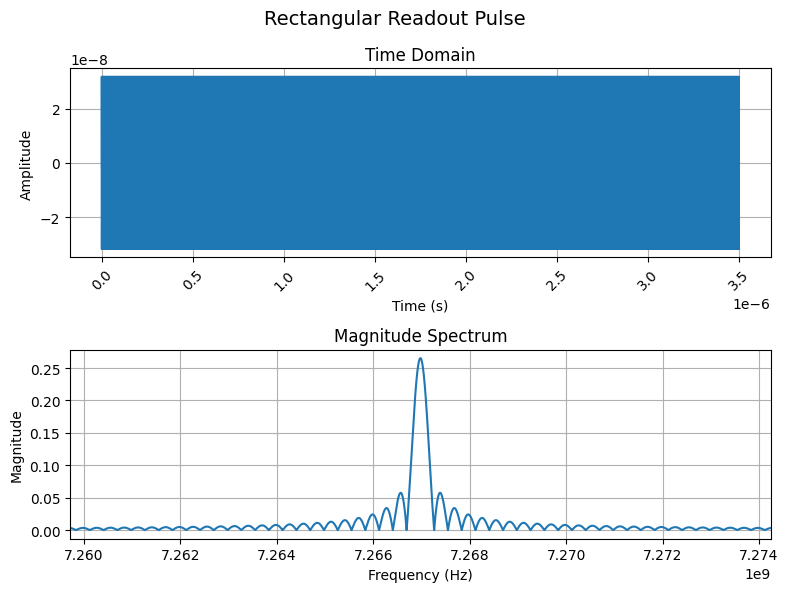

100%|██████████| 500/500 [01:33<00:00,  5.32it/s, Transited Pulse |1>]


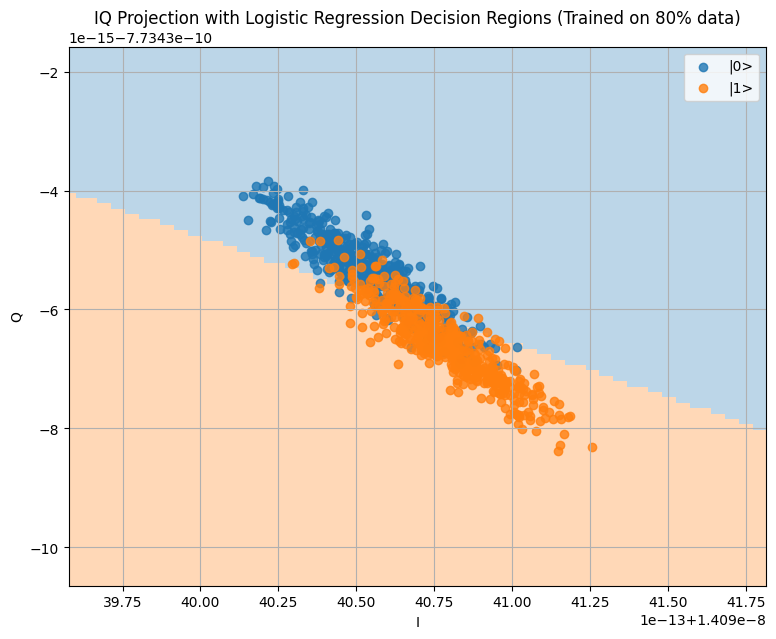

fidelity = 0.835
CPU times: user 8.99 s, sys: 3.62 s, total: 12.6 s
Wall time: 3min 31s


In [8]:
%%time
run(pulse_samples_number=2 ** 23)